# Assignment 2: CRF sequence tagging for Move Queries

## Amaya Syed 

In [139]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import re
import unicodedata

from copy import deepcopy
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

The aim of this assignment is to correctly classify queries regarding movie related topics, such as: 

- O	what
- O	movies
- O	star
- B-ACTOR	bruce
- I-ACTOR	willis.

Each word in the query has been manually tagged and assigned to one of several possible categories: 

- B-ACTOR   
- B-CHARACTER 
- B-DIRECTOR 
- B-GENRE 
- B-PLOT 
- B-RATING 
- B-RATINGS_AVERAGE 
- B-REVIEW 
- B-SONG 
- B-TITLE 
- B-TRAILER 
- B-YEAR 
- I-ACTOR 
- I-CHARACTER 
- I-DIRECTOR 
- I-GENRE 
- I-PLOT 
- I-RATING 
- I-RATINGS_AVERAGE 
- I-REVIEW 
- I-SONG 
- I-TITLE 
- I-TRAILER 
- I-YEAR
- O

referring to the the information content of the word and where B refers to the Beginning word and I the inside word in a sequence of words relating to the same topic, be it a name (Director, Actor) or a title for example. As these queries contain sequential relations, we will train a Conditional Random Field tagger to correctly identify word tags. In the **part 1** of the assignment (Question 1, 2, 3) we will only run basic preprocessing and we'll look at which words are being misclassified (both True and False Positives) and think about what could be done to improve the classification accuracy. In the **part 2** (Question 4), we'll add POS tags to each word and check how this improves accuracy. Finally in **part 3** (Question 5), we will modify the features inputed to training and try and maximise the macro-average f1-score. 


# Part 1

In [2]:
# This function loads the data, tokenises the data and returns a list where each element is a tuple containing the tuple and its category tag. 

def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    O	a
    O	great
    O	lunch
    O	spot
    O	but
    B-Hours	open
    I-Hours	till
    I-Hours	2
    I-Hours	a
    I-Hours	m
    B-Restaurant_Name	passims
    I-Restaurant_Name	kitchen
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data


In [3]:
# here we load the data and take a look at the it shape and length

raw_training_data = get_raw_data_from_bio_file("engtrain.bio.txt")

# have a look at the first example
print(raw_training_data[0])

print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
9775 instances
99491 words


In [4]:
# for now, no preprocessing (NPP)

def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    
    return preprocessed_example   

## Question 1 : split the training set into a training and development set, with 80-20% of data each.

In [5]:
# here we split the training data, into a training and dev set. 

orginial_training_data = [preProcess(example) for example in raw_training_data]

cut = len(orginial_training_data) * 8 // 10  # define the index number in which to perform the cut by multiplying by 8 and returning the largest possible integer (floor division)

training_data = orginial_training_data[ :cut] # using the index number calculated above, cut the list giving us an 80% to training set
test_data = orginial_training_data[cut: ] # assigning the end 20% to the development set, called testing set for convenience

# check the effect of pre-processing
#print(training_data[0])

[('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]


In [6]:
# this function will extract features from the dataset and return them as a list containing strings, which can then be inputed into tbe CRF tagger train method. No modification for now. 

_pattern = re.compile(r"\d")  # to recognize numbers/digits    

def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list

    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])

    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [7]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)

print("done")

training tagger...
done


In [8]:
# here we apply our trained model to the development set

print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [27]:
# We output the classification report and save it for future use. 

NPP_results = classification_report(y_test, preds, output_dict=False)
print(NPP_results)

                   precision    recall  f1-score   support

          B-ACTOR       0.65      0.87      0.74       433
      B-CHARACTER       0.70      0.32      0.44        44
       B-DIRECTOR       0.76      0.63      0.69       365
          B-GENRE       0.96      0.97      0.97       927
           B-PLOT       0.48      0.43      0.45       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.88      0.88      0.88       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.50      0.25      0.33        20
          B-TITLE       0.66      0.35      0.46       679
        B-TRAILER       1.00      0.50      0.67        28
           B-YEAR       0.89      1.00      0.94       535
          I-ACTOR       0.66      0.85      0.74       482
      I-CHARACTER       0.58      0.60      0.59        47
       I-DIRECTOR       0.76      0.62      0.68       410
          I-GENRE       0.90      1.00      0.95       

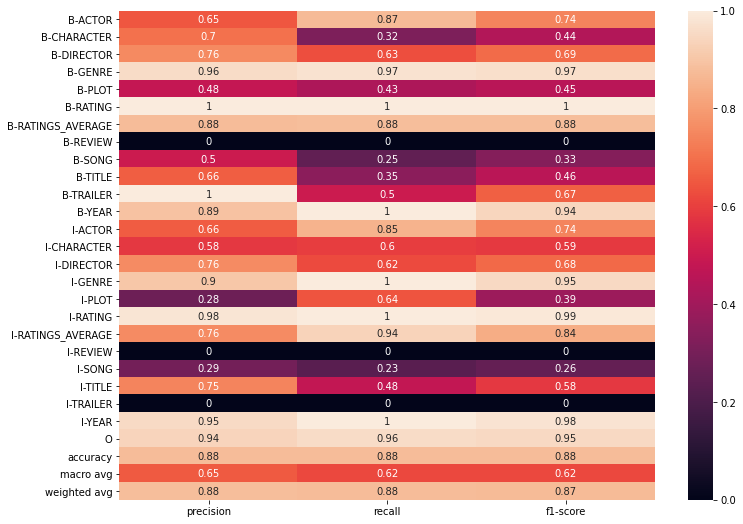

In [20]:
NPP_resultsDict = classification_report(y_test, preds, output_dict=True)
df_NPP_resultsDict = pd.DataFrame(NPP_resultsDict)

plt.figure(figsize=(12, 9))
sns.heatmap(df_NPP_resultsDict.iloc[:-1, :].T, annot=True)

The overall accuracy achieved is 0.88 for precision, recall and f1-score, which is already a relatively high accuracy score. Straight away we can see that three categories have 0 % accuracy: B-Review, I-Review and I-Trailer. On the other hand B-Genre, I-Genre, B-Year, I-Rating, I-Year and O achieve a high classification accuracy without any tweaking, whereas B-Song, I-Song, I-Plot have relatively low accuracy and B-I Actor, Character and Director achieve intermediate scores. 

When looking a the confusion matrix we can get a clearer vision of where the misclassifications are occuring. The most misclassifications occur in the O category - which is a sort of miscellaneous class of words that have no clear labels - but its also by far the category with the most correct classfication, high accuracy (95%) and highest support (12447). There also seems to be some confusion between I-Plot and I-Title (165), between Actor and Directors (106) and between I-Actor and I-Title (71), amongst others. 

In [25]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j], ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    plt.show()

C:\Users\Amaya\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['B-PLOT', 'I-CHARACTER', 'I-GENRE', 'B-REVIEW', 'B-CHARACTER', 'I-RATING', 'I-TRAILER', 'B-YEAR', 'B-ACTOR', 'B-TRAILER', 'I-DIRECTOR', 'B-DIRECTOR', 'I-RATINGS_AVERAGE', 'I-TITLE', 'I-YEAR', 'B-TITLE', 'I-PLOT', 'B-GENRE', 'B-RATINGS_AVERAGE', 'I-REVIEW', 'O', 'I-SONG', 'B-RATING', 'B-SONG', 'I-ACTOR'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


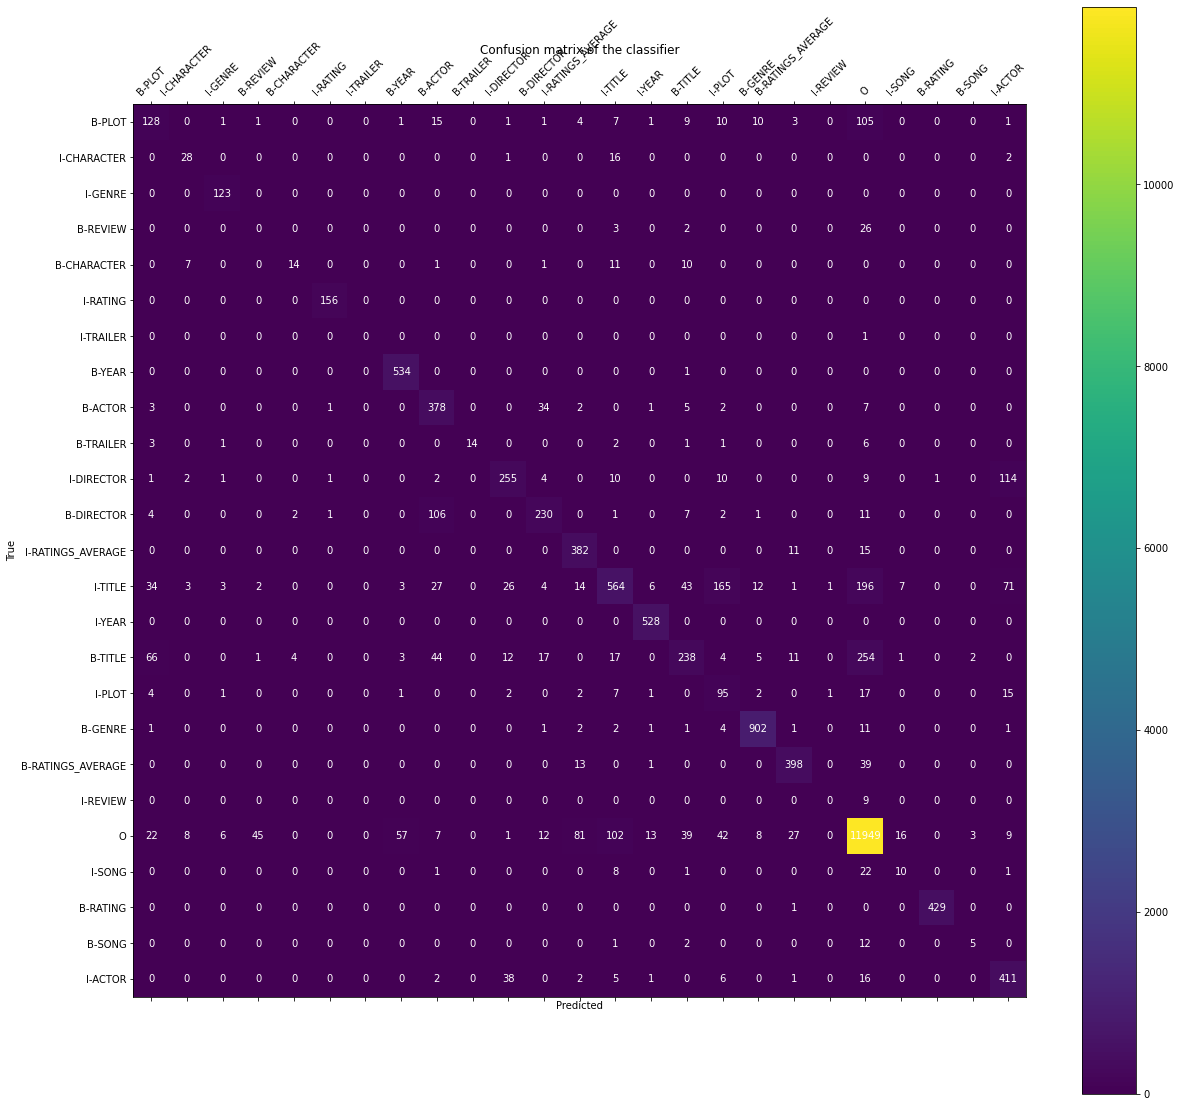

In [26]:
confusion_matrix_heatmap(y_test, preds)

## Question 2 - Error analysis 1: False positives

False positive results incorrectly assign a category to the token, when the ground truth label is a different category. In other words, the token is considered positive for a category it does not belong to. We will look at the False positive results obtained in the five worst performing categories based on the precision score: B-Review, I-Review, I-Trailer, I-PLot and I-Song. First we copy the report we produced above and delete the overall accuracy results (*cleanResultsDict*). 

In [21]:
cleanResultsDict = deepcopy(NPP_resultsDict) # copy report 

for key in ['weighted avg', 'macro avg', 'accuracy' ]: # delete overall results
    del cleanResultsDict[key]

We then ask for the *precision* key in our dictionary and extract the numerical results associated for each category (*precisionResults*). We sort these results and keep the first five, which correspond to the worst classes (*worstClasses*). We then loop over these classes (*badClass*), as well as over each each element in the test data (*testElement*) for that class and keep the predicted element (*predElement*). The tag of the predicted elements is then compared to the real tag and if these do not match, that sentence is printed, as well as the actual tokens and tags that do not match. 

In [48]:
#False Positives for worst precision classes

precisionResults = [(cleanResultsDict[key]['precision'], key) for key in cleanResultsDict.keys() ] # 
worstClassesP = [t[1] for t in sorted(precisionResults)[:5]]

print(worstClassesP)

for badClass in worstClassesP: # we go over each of the worst performing classes
    print('====== FALSE POSITIVE FOR CLASS %s ==========================================================================================================================' %badClass)
    
    for testElement in test_data: # and within each class, each element 
        predElement = ct.tag([s[0] for s in testElement]) # keep predicted tag of each element
        
        for pair in zip(testElement, predElement): # now loop over the predicted and ground truth element
            if (pair[0][1] != pair[1][1]) and  pair[1][1] == badClass: # compare predicted tag against ground truth
                
                print(testElement) # print sentence where tags do not match
                print( ' - FALSE POSITIVE:  ', pair, '--------------------------------------------') # print tokens and the tags
                break
        

['B-REVIEW', 'I-REVIEW', 'I-TRAILER', 'I-PLOT', 'I-SONG']
====== FALSE POSITIVE FOR CLASS B-REVIEW ==========================================================================================================================
[('what', 'O'), ('is', 'O'), ('expected', 'O'), ('to', 'O'), ('be', 'O'), ('the', 'O'), ('best', 'O'), ('action', 'B-GENRE'), ('movie', 'O'), ('of', 'O'), ('the', 'O'), ('year', 'O')]
 - FALSE POSITIVE:   (('best', 'O'), ('best', 'B-REVIEW')) --------------------------------------------
[('what', 'O'), ('is', 'O'), ('the', 'O'), ('best', 'O'), ('action', 'B-GENRE'), ('movie', 'O'), ('from', 'O'), ('the', 'O'), ('last', 'B-YEAR'), ('nine', 'I-YEAR'), ('decades', 'I-YEAR'), ('staring', 'O'), ('mark', 'B-ACTOR'), ('harmon', 'I-ACTOR'), ('with', 'O'), ('a', 'O'), ('pg', 'B-RATING'), ('13', 'I-RATING'), ('rating', 'O')]
 - FALSE POSITIVE:   (('best', 'O'), ('best', 'B-REVIEW')) --------------------------------------------
[('what', 'O'), ('is', 'O'), ('the', 'O'), ('best',

For the category B-Review one of the words consistently miscategorised is the word "best", when the ground truth label is actually O. It would seem these tokens are miscontrued as being the expression of an opinion about a movie, hence being assigned to the Review category, whereas they are actually an expression of how the movie is perceived by the public - successful or not. We do notice that all or most of these sentences contain a reference to movie/s, film/s, or GENRE. We posit that adding surrounding context to the features might help disambiguate between these categories. The I-Review errors are not numerous and follow words such as "best" and "sweetest" which migth confound the classification. 

The next big category is I-Plot, where a wide variety of words are mistaken to refer to plot descriptions or devices, when they are actually part of TITLE or O. There doesn't seem to be a clear pattern to the mistakes, but again these are easy mistakes to make as the tokens very easily could refer to plot. Again, surrouding context would probaly help to reduce error here. 

I-Song seems to be incorrectly assigned to tokens when the words Song or Soundtrack are present in the sentence. 

## Question 3 - Error analysis 2: False negatives

False negative results also incorrectly classify a token to a category, when the ground truth category is different. The difference is in the perspective, as we considere false negative from the ground truth tag perspective, hence the token is not considered to be part of that category when it should be.  We will look at the False positive results obtained in the five worst performing categories using the Recall scores: B-Review, I-Review, I-Trailer, I-PLot and I-Song. First we copy the report we produced above and delete the overall accuracy results (*cleanResultsDict*). The algorithm to find these pair works exactly as before, expect we use the dictionary key *recall*. The worst performing categories are the same as above: B-Review, I-Review, I-Trailer, I-Song and B-Song.

In [47]:
#False Negatives for worst recall classes

recallResults = [(cleanResultsDict[key]['recall'], key) for key in cleanResultsDict.keys() ] # using recall to keep accuracy results for each category
worstClassesR = [t[1] for t in sorted(recallResults)[:5]]   

print(worstClassesR)

for badClass in worstClassesR:
    print('====== FALSE NEGATIVE FOR CLASS %s ==========================================================================================================================' %badClass)
    
    for testElement in test_data:
        predElement = ct.tag([s[0] for s in testElement])
        
        for pair in zip(testElement, predElement):
            if (pair[0][1] != pair[1][1]) and  pair[0][1] == badClass:
                
                print(testElement)
                print(' - FALSE NEGATIVE:  ', pair, '--------------------------------------------')
                break
        

['B-REVIEW', 'I-REVIEW', 'I-TRAILER', 'I-SONG', 'B-SONG']
====== FALSE NEGATIVE FOR CLASS B-REVIEW ==========================================================================================================================
[('can', 'O'), ('you', 'O'), ('show', 'O'), ('me', 'O'), ('some', 'O'), ('reviews', 'B-REVIEW'), ('for', 'O'), ('purple', 'B-TITLE'), ('rain', 'I-TITLE')]
 - FALSE NEGATIVE:   (('reviews', 'B-REVIEW'), ('reviews', 'O')) --------------------------------------------
[('where', 'O'), ('can', 'O'), ('i', 'O'), ('find', 'O'), ('good', 'O'), ('reviews', 'B-REVIEW'), ('about', 'O'), ('the', 'O'), ('movie', 'O'), ('purple', 'B-TITLE'), ('rain', 'I-TITLE')]
 - FALSE NEGATIVE:   (('reviews', 'B-REVIEW'), ('reviews', 'O')) --------------------------------------------
[('what', 'O'), ('are', 'O'), ('people', 'B-REVIEW'), ('saying', 'I-REVIEW'), ('about', 'O'), ('purple', 'B-TITLE'), ('rain', 'I-TITLE')]
 - FALSE NEGATIVE:   (('people', 'B-REVIEW'), ('people', 'O')) --------------

For the B-Review category all the tokens are misclassified as O. Words suchs as *reviews, people, comments, opinions* are being predicted as O, when they are actually B-Review. Given the small support for the B-Review category (31), its to be expected that despite words such as *review* being used - which should easily be classified to the review category - the model isn't receiving enough training to fully recognized it. More training samples in that category would be needed to improve the classification accuracy significantly. The same goes for I-Review, with a support of 9, where words following a B-Review words like those above, such as *saying, think, good*. 

Small, short words such as *the* and *what* are being misclassified as O, when they are actually part of song title. Adding additonal context to the feature can also help here. The same goes for I-Song, where words such as *over*, *come*, *you* are being assigned to O instead of Song. 

# Part 2

# Question 4 - POS tagging 

We will now modify the **preProcess** function, which will "glue" together the token and the POS tag assigned by **CRFTagger()** in *posttagger*, with an '@' symbol in between them. We will then use the '@' in **get_features** to "unglue" the token and its POS tag. We will then add the POS tag as a feature used for training and compare with the previous result. 

In [50]:

def preProcess(sentence, tagger=None):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('what', 'O'), ('movies', 'O'), ('star', 'O'), ('bruce', 'B-ACTOR'), ('willis', 'I-ACTOR')]
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""
    
    if tagger:
        taggedTokens = [ s[0]+'@'+s[1] for s in tagger.tag([t[0] for t in sentence] )] # glueing the token and the tag assigned by CRFTagger()
        return [(taggedTokens[i], sentence[i][1]) for i in range(len(sentence))] # returning the glued token@tag and the category tag. 
    
    return sentence # if there is no tagger, we just return the unmodified sentence. 

In [51]:
posttagger = CRFTagger() # we initialise the tagger 
posttagger.set_model_file("crf_pos.tagger") # POS tagger

orginial_training_data = [preProcess(sentence, posttagger) for sentence in raw_training_data] # we apply the preprocessing to the raw data

# cut into 80-20 train-dev datasets
cut = len(orginial_training_data) * 8 // 10 

training_data = orginial_training_data[:cut] 
test_data = orginial_training_data[cut:]


In [52]:
# check the effect of pre-processing
print(training_data[0])

[('what@WP', 'O'), ('movies@VBZ', 'O'), ('star@NNP', 'O'), ('bruce@NNP', 'B-ACTOR'), ('willis@NNP', 'I-ACTOR')]


In [57]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    feature_list = []
    split_tokens = []
    split_postag = []
    
    
    # Disambiguating between POS tagged words and non tagged words and adding them to the feature list
    for token in tokens: 
        if '@' in token: # we use @ to unglue the tokens 
            split_token = token.split("@")[0] # then we split them and keep them split_token and postag
            postag = token.split("@")[1]
            
            # here we keep all the tokens and tags for future use. 
            split_tokens.append(split_token) # append the token here 
            split_postag.append(postag) # append the pos tag here 

        else: 
            split_token = token
            split_tokens.append(split_token)

    tokens = split_tokens    
    token = split_tokens[idx] # reasigning the element idx of split token to token for ease of use of the code. 
    
    if not token:
        return feature_list
    
    # adding the word and its POS tag
    feature_list.append("WORD_" + token.lower())
    
    feature_list.append('POS_' + split_postag[idx]) # here we add the postag as a feature of the feature list presented for training. 

    # Capitalization - True/False 
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number - True/False
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Suffix up to length 3  # and this too.
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])

    return feature_list

In [58]:
# Train the CRF BIO-tag tagger with the postags
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)

print("done")

training tagger...
done


In [59]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [60]:
# Output the classification report (which you should save each time for comparing your models)

pos_results = classification_report(y_test, preds, output_dict=False)
print(pos_results)

                   precision    recall  f1-score   support

          B-ACTOR       0.65      0.85      0.73       433
      B-CHARACTER       0.68      0.34      0.45        44
       B-DIRECTOR       0.75      0.64      0.69       365
          B-GENRE       0.96      0.97      0.97       927
           B-PLOT       0.46      0.48      0.47       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.88      0.89      0.89       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.54      0.35      0.42        20
          B-TITLE       0.68      0.34      0.45       679
        B-TRAILER       1.00      0.54      0.70        28
           B-YEAR       0.89      1.00      0.94       535
          I-ACTOR       0.65      0.83      0.73       482
      I-CHARACTER       0.55      0.60      0.57        47
       I-DIRECTOR       0.75      0.64      0.69       410
          I-GENRE       0.90      1.00      0.95       

C:\Users\Amaya\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


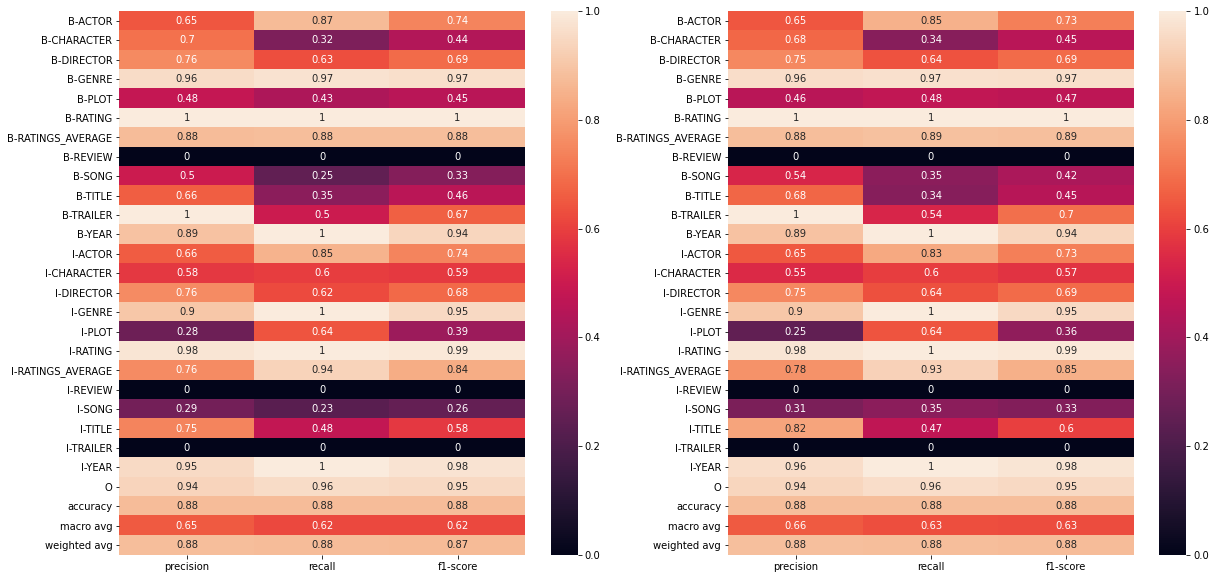

In [69]:
pos_resultsDict = classification_report(y_test, preds, output_dict=True)
df_pos_resultsDict = pd.DataFrame(pos_resultsDict)


plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.heatmap(df_NPP_resultsDict.iloc[:-1, :].T, annot=True)


plt.subplot(1, 2, 2)
sns.heatmap(df_pos_resultsDict.iloc[:-1, :].T, annot=True)


The main result is that there's scarcely any difference in the results, despite adding the POS tag, with a 0.01 increase in the macro average accuracy (63%). This is probably due to the fact we need to add more information about surrounding words in the sentence, therefore adding context, rather than adding more information on the same word. There are some differences in the results obtained per category however, with minimal 0.01-0.05 fluctuations in accuracy. Notably I-Title accuracy goes from 0.75 to 0.82 in precision and I-Song goes up in recall from 0.23 to 0.35. I-Song goes from 10 to 15 correct classifications, whereas I-Title goes from 564 to 558, but many less have been falsely attributed to the O category (102 to 61). 

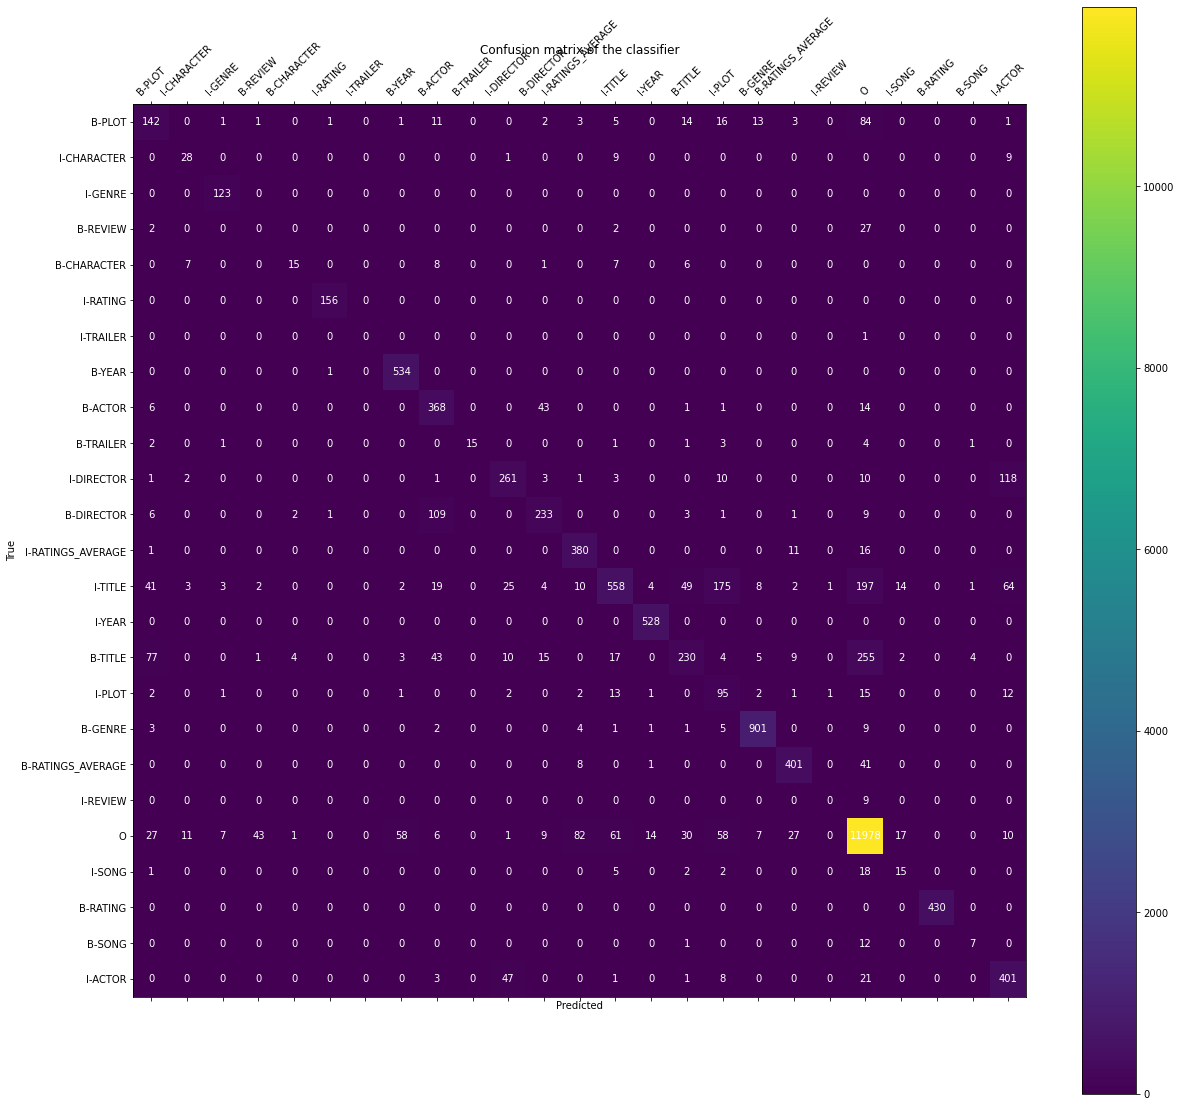

In [65]:
confusion_matrix_heatmap(y_test, preds)

# Part 4

## Question 5

We will now see if by adding suitable features in the **get_features** function we get obtain a better macro-average accuracy. The macro average is the arithmetic mean of the per class f1-scores. First we will incrementally modify the function and run a classification report. To do so, one can sequentially uncomment the function as marked in the comments and run the corresponding results. Finally, we run the full **get_features** function on the full training and testing set. 

In [112]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    feature_list = []
    split_tokens = []
    split_postag = []
    
    
    # disambiguating between POS tagged words and non tagged words and adding them to the feature list
    for token in tokens:
        if '@' in token:
            split_token = token.split("@")[0]
            postag = token.split("@")[1]
            split_tokens.append(split_token)
            split_postag.append(postag)
        else: 
            split_token = token
            split_tokens.append(split_token)

    tokens = split_tokens    
    token = split_tokens[idx]
    
    if not token:
        return feature_list
    
    # Capitalization - True/False 
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number - True/False
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")
        
# =====================================================  
# TO OBTAIN RESULTS BELOW UNCOMMENT SEQUENTIALLY
# =====================================================
#
# UNCOMMENT HERE FOR RESULTS1
#
#    # Suffix up to length 3  # and this too - cf results1
#    if len(token) > 1:
#        feature_list.append("SUF_" + token[-1:])
#        feature_list.append('PRE_' + token[0])
#    if len(token) > 2:
#        feature_list.append("SUF_" + token[-2:])
#        feature_list.append('PRE_' + token[:2])
#    if len(token) > 3:
#        feature_list.append("SUF_" + token[-3:])
#        feature_list.append('PRE_' + token[:3])
#    if len(token) > 4:
#        feature_list.append("SUF_" + token[-4:])
#        feature_list.append('PRE_' + token[:4])
#        
#    # adding the word and its POS tagf
#    feature_list.append("WORD_" + token.lower())
#    
#    feature_list.append('POS_' + split_postag[idx])
#
# ----------------------------------------------------    
#
# UNCOMMENT HERE FOR RESULTS2
#
#    # adding a tag for short or long words 
#    if len(token) < 4:
#        feature_list.append('SHORT')
#
# ----------------------------------------------------
# UNCOMMENT HERE FOR RESULTS3

#    # adding token n-1 and postag    
#    if idx > 0: 
#        
#        feature_list.append('WORD-1_' + split_tokens[idx-1].lower())
#        feature_list.append('POS-1_' + split_postag[idx-1])
#        
#    # adding a tag to indicate the start of the document    
#    else:
#        feature_list.append('START')
#  
# -----------------------------------------------------
# UNCOMMENT HERE FOR RESULTS4
#        
#    # adding token n+1 and postag    
#    if idx < len(split_tokens)-1:    
#        
#        feature_list.append('WORD+1_' + split_tokens[idx+1].lower())
#        feature_list.append('POS+1_' + split_postag[idx+1])
#        
#    # adding and End tag to indicate end of document    
#    else:
#        feature_list.append('END')
#
# ----------------------------------------------------
# UNCOMMENT HERE FORE RESULTS5
#
#    # adding token n-3
#    if idx > 2: # cf results4
#        feature_list.append('WORD-3_' + split_tokens[idx-3].lower())
#        
#    if idx < len(split_tokens)-3:   
#        feature_list.append('WORD+3_' + split_tokens[idx+3].lower())

    
    return feature_list

In [109]:
# Train the CRF BIO-tag tagger with the postags
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)

print("done")

training tagger...
done


In [110]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [74]:
# adding a suffix and prefix for token n - up to four letter
results1 = classification_report(y_test, preds, output_dict=False)
print(results1)

# macro avg       0.66      0.64      0.64     20225

                   precision    recall  f1-score   support

          B-ACTOR       0.70      0.89      0.79       433
      B-CHARACTER       0.58      0.25      0.35        44
       B-DIRECTOR       0.79      0.66      0.72       365
          B-GENRE       0.97      0.99      0.98       927
           B-PLOT       0.59      0.66      0.62       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.89      0.90      0.89       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.35      0.35      0.35        20
          B-TITLE       0.68      0.38      0.49       679
        B-TRAILER       0.94      0.54      0.68        28
           B-YEAR       0.96      1.00      0.98       535
          I-ACTOR       0.71      0.87      0.78       482
      I-CHARACTER       0.55      0.34      0.42        47
       I-DIRECTOR       0.78      0.66      0.72       410
          I-GENRE       0.93      1.00      0.96       

In [78]:
# adding a SHORT tag for words up to three letter long
results2 = classification_report(y_test, preds, output_dict=False)
print(results2)

#  macro avg       0.66      0.64      0.64     20225

                   precision    recall  f1-score   support

          B-ACTOR       0.71      0.88      0.79       433
      B-CHARACTER       0.52      0.25      0.34        44
       B-DIRECTOR       0.79      0.66      0.72       365
          B-GENRE       0.97      0.98      0.98       927
           B-PLOT       0.57      0.69      0.62       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.89      0.90      0.89       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.37      0.35      0.36        20
          B-TITLE       0.69      0.38      0.49       679
        B-TRAILER       0.94      0.54      0.68        28
           B-YEAR       0.96      1.00      0.98       535
          I-ACTOR       0.72      0.87      0.78       482
      I-CHARACTER       0.53      0.34      0.42        47
       I-DIRECTOR       0.79      0.65      0.71       410
          I-GENRE       0.93      1.00      0.96       

In [82]:
# adding the n-1 token and postag + a START tag if token is first word in sentence
results3 = classification_report(y_test, preds, output_dict=False)
print(results3)

# macro avg       0.75      0.70      0.71     20225

                   precision    recall  f1-score   support

          B-ACTOR       0.84      0.96      0.90       433
      B-CHARACTER       0.71      0.34      0.46        44
       B-DIRECTOR       0.94      0.88      0.91       365
          B-GENRE       0.97      0.98      0.98       927
           B-PLOT       0.79      0.79      0.79       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.92      0.91      0.91       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.64      0.35      0.45        20
          B-TITLE       0.83      0.64      0.72       679
        B-TRAILER       1.00      0.39      0.56        28
           B-YEAR       0.96      0.99      0.97       535
          I-ACTOR       0.84      0.94      0.89       482
      I-CHARACTER       0.61      0.57      0.59        47
       I-DIRECTOR       0.94      0.86      0.90       410
          I-GENRE       0.95      1.00      0.97       

In [89]:
# adding the n+1 token and postag + a END tag if token is first word in sentence
results4 = classification_report(y_test, preds, output_dict=False)
print(results4)

# macro avg       0.75      0.69      0.70     20225
# this brings the accuracy down slightly, so will take it off for now. 

                   precision    recall  f1-score   support

          B-ACTOR       0.83      0.96      0.89       433
      B-CHARACTER       0.77      0.23      0.35        44
       B-DIRECTOR       0.95      0.87      0.91       365
          B-GENRE       0.97      0.97      0.97       927
           B-PLOT       0.78      0.78      0.78       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.90      0.91      0.91       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.62      0.40      0.48        20
          B-TITLE       0.83      0.67      0.74       679
        B-TRAILER       1.00      0.43      0.60        28
           B-YEAR       0.89      0.99      0.94       535
          I-ACTOR       0.83      0.94      0.88       482
      I-CHARACTER       0.67      0.34      0.45        47
       I-DIRECTOR       0.95      0.85      0.89       410
          I-GENRE       0.93      1.00      0.96       

In [93]:
# adding the n+3 and n-3 token
results5 = classification_report(y_test, preds, output_dict=False)
print(results5)

# macro avg       0.77      0.70      0.71     20225

                   precision    recall  f1-score   support

          B-ACTOR       0.84      0.97      0.90       433
      B-CHARACTER       0.85      0.25      0.39        44
       B-DIRECTOR       0.95      0.88      0.91       365
          B-GENRE       0.97      0.98      0.97       927
           B-PLOT       0.80      0.80      0.80       298
         B-RATING       1.00      1.00      1.00       430
B-RATINGS_AVERAGE       0.91      0.94      0.93       451
         B-REVIEW       0.00      0.00      0.00        31
           B-SONG       0.75      0.45      0.56        20
          B-TITLE       0.84      0.68      0.75       679
        B-TRAILER       1.00      0.39      0.56        28
           B-YEAR       0.90      0.99      0.94       535
          I-ACTOR       0.84      0.94      0.88       482
      I-CHARACTER       0.71      0.32      0.44        47
       I-DIRECTOR       0.95      0.85      0.90       410
          I-GENRE       0.95      1.00      0.97       

## Training with the full data set and testing on test data

Now that we've added feature, we will run them on the full training and testing set. 

In [130]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    feature_list = []
    split_tokens = []
    split_postag = []
    
    
    # disambiguating between POS tagged words and non tagged words and adding them to the feature list
    for token in tokens:
        if '@' in token:
            split_token = token.split("@")[0]
            postag = token.split("@")[1]
            split_tokens.append(split_token)
            split_postag.append(postag)
            #print(split_tokens)
        else: 
            split_token = token
            split_tokens.append(split_token)
            #print(split_tokens)

    tokens = split_tokens    
    token = split_tokens[idx]
    
    if not token:
        return feature_list
    
    # Capitalization - True/False 
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number - True/False
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Suffix and prefix up to length 4 
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
        feature_list.append('PRE_' + token[0])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
        feature_list.append('PRE_' + token[:2])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        feature_list.append('PRE_' + token[:3])
    if len(token) > 4:
        feature_list.append("SUF_" + token[-4:])
        feature_list.append('PRE_' + token[:4])
        
    # adding the word and its POS tagf
    feature_list.append("WORD_" + token.lower())
    
    feature_list.append('POS_' + split_postag[idx])
    
    # adding a tag for short or long words
    if len(token) < 4:
        feature_list.append('SHORT')
        
    # adding token n-1 and postag    
    if idx > 0:
        
        feature_list.append('WORD-1_' + split_tokens[idx-1].lower())
        feature_list.append('POS-1_' + split_postag[idx-1])
    
    # adding Start tag to indicate beginning of document
    else:
        feature_list.append('START')
    
    # adding token n+1 and postage
    if idx < len(split_tokens)-1:    
        
        feature_list.append('WORD+1_' + split_tokens[idx+1].lower())
        feature_list.append('POS+1_' + split_postag[idx+1])
        
    # adding End tag to indicate end of document   
    else:
        feature_list.append('END')
        
    # adding token n-3    
    if idx > 2:
        feature_list.append('WORD-3_' + split_tokens[idx-3].lower())
        
    # adding token n+3    
    if idx < len(split_tokens)-3:    
        feature_list.append('WORD+3_' + split_tokens[idx+3].lower())
        

    return feature_list

In [126]:
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")

orginial_training_data = [preProcess(sentence, posttagger) for sentence in raw_training_data]

# check the effect of pre-processing
print(orginial_training_data[0])

[('what@WP', 'O'), ('movies@VBZ', 'O'), ('star@NNP', 'O'), ('bruce@NNP', 'B-ACTOR'), ('willis@NNP', 'I-ACTOR')]


In [131]:
# train on all available training data
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("ALL training tagger...")
ct.train(orginial_training_data, TAGGER_PATH)

print("done")

ALL training tagger...
done


In [117]:
# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("engtest.bio.txt")
test_data = [preProcess(sentence, posttagger) for sentence in  raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")


2443 instances
24686 words


In [128]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")


testing tagger...
done


In [129]:
# Output the classification report (which you should save each time for comparing your models)

final_results = classification_report(y_test, preds, output_dict=False)
print(final_results)

                   precision    recall  f1-score   support

          B-ACTOR       0.89      0.94      0.91       812
      B-CHARACTER       0.81      0.51      0.63        90
       B-DIRECTOR       0.92      0.83      0.87       456
          B-GENRE       0.93      0.95      0.94      1117
           B-PLOT       0.72      0.66      0.69       491
         B-RATING       0.98      0.97      0.97       500
B-RATINGS_AVERAGE       0.93      0.89      0.91       451
         B-REVIEW       0.45      0.09      0.15        56
           B-SONG       0.82      0.52      0.64        54
          B-TITLE       0.80      0.81      0.81       562
        B-TRAILER       0.81      0.87      0.84        30
           B-YEAR       0.96      0.94      0.95       720
          I-ACTOR       0.87      0.93      0.90       862
      I-CHARACTER       0.69      0.39      0.50        75
       I-DIRECTOR       0.91      0.83      0.87       496
          I-GENRE       0.88      0.71      0.79       

In [ ]:
final_resultsDict = classification_report(y_test, preds, output_dict=True)
df_final_resultsDict = pd.DataFrame(final_resultsDict)

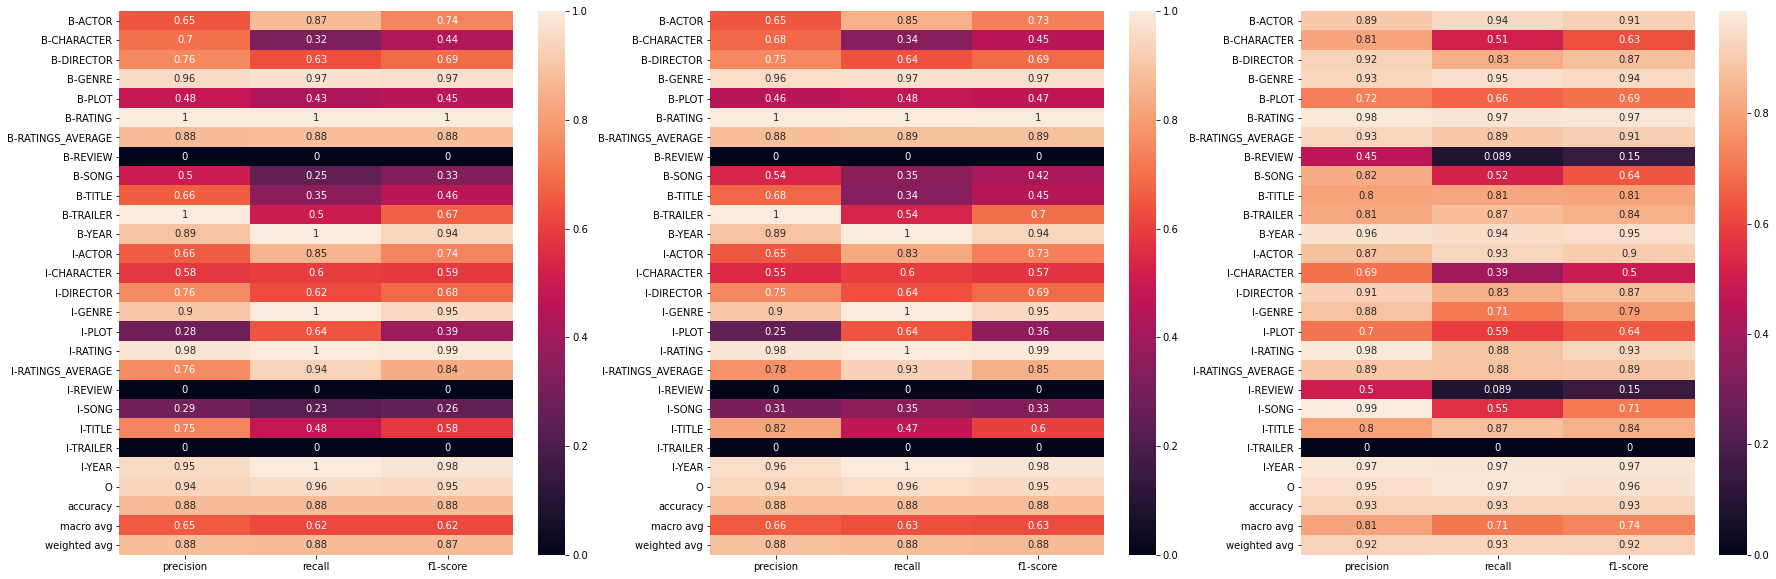

In [138]:

plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
sns.heatmap(df_NPP_resultsDict.iloc[:-1, :].T, annot=True)


plt.subplot(1, 3, 2)
sns.heatmap(df_pos_resultsDict.iloc[:-1, :].T, annot=True)

plt.subplot(1, 3, 3)
sns.heatmap(df_final_resultsDict.iloc[:-1, :].T, annot=True)

By training on the whole training set, we obtain a 74% macro-average f1 accuracy score - up from 62% originally - which represents a definite improvement. This was mainly obtained by adding tokens up and downstream from the token - specifically tokens n-3, n-1, n, n+1, n+3. The POS tags were added for token n, n-1 and n+1, but not for n-3 and n+3 as we found keeping them lowered the average slightly. This is in line with the notion that more context information is needed to disambiguate between categories, rather than more information on a given token. We can see a significant increase in macro average in almost all categories, except I-Genre and I-Trailer. I-Trailer is still in 0, but it has a support of 8, so its unlikely that can be bettered much. I-Genre is being misclassified in O (38), whereas it was being perfectly classified previously. It's unclear what this could be due to. I-Director and I-Actor are still misclassified quite a lot, down from 161 in total to 77 total. Maybe using a better dictionary of actor and director names would help improve this. 

The worst classes are now I-TRAILER, B-REVIEW, I-REVIEW, I-CHARACTER, B-CHARACTER and I-PLOT and the large majority of these are all predicted as O. The category 0 is still the one with the most misclassifications and most correct classifications, as there are many words included in O which could easily be mistaken to belong to another category if one looks at the words being misclassified bellow. Additionally, the rationale behind the ground truth tag labelling is not always clear, when looking at the *engtrain.txt* itself, so its not entirely surprising that this ambiguity is also seen in the classification results. 

Overall, a definite improvement in macro average f1 score was achieved, with room for improvement. Maybe a dictionary with actor, director and character names might help, as well as a clearer labelling of the O class. 

C:\Users\Amaya\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=['B-PLOT', 'I-CHARACTER', 'I-GENRE', 'B-REVIEW', 'B-CHARACTER', 'I-RATING', 'I-TRAILER', 'B-YEAR', 'B-ACTOR', 'B-TRAILER', 'I-DIRECTOR', 'I-TITLE', 'I-RATINGS_AVERAGE', 'B-DIRECTOR', 'I-YEAR', 'B-TITLE', 'I-PLOT', 'B-GENRE', 'B-RATINGS_AVERAGE', 'I-REVIEW', 'O', 'I-SONG', 'B-RATING', 'B-SONG', 'I-ACTOR'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


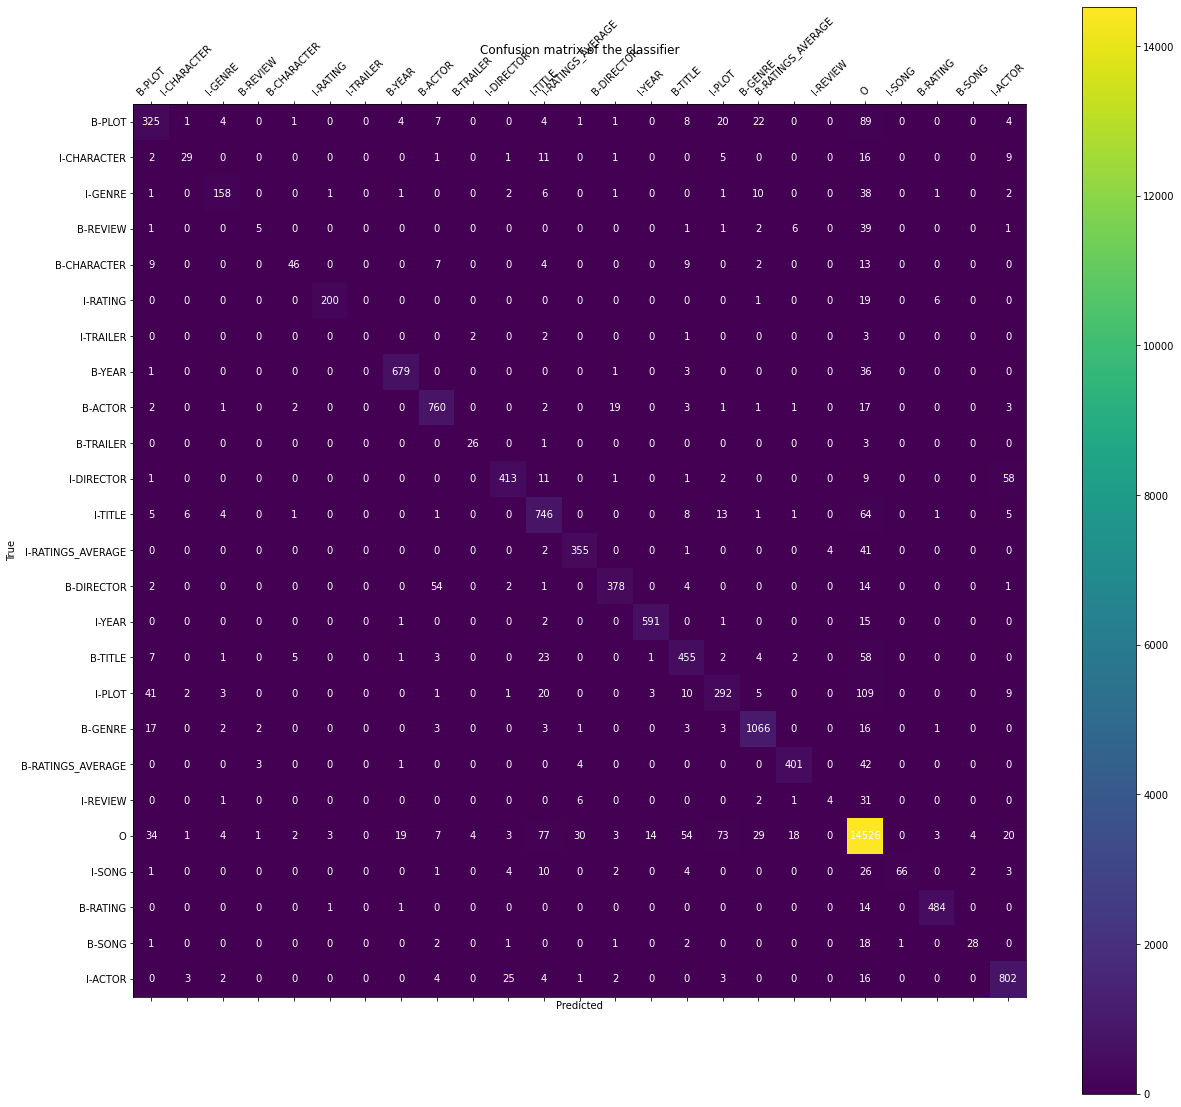

In [133]:
confusion_matrix_heatmap(y_test, preds)

In [134]:
cleanResultsDict = deepcopy(final_resultsDict)

for key in ['weighted avg', 'macro avg', 'accuracy' ]:
    del cleanResultsDict[key]

precisionResults = [(cleanResultsDict[key]['precision'], key) for key in cleanResultsDict.keys() ]
worstClassesP = [t[1] for t in sorted(precisionResults)[:5]]  

In [136]:
#False Positives for worst precision classes
               
precisionResults = [(cleanResultsDict[key]['precision'], key) for key in cleanResultsDict.keys() ] # 
worstClassesP = [t[1] for t in sorted(precisionResults)[:5]]

print(worstClassesP)

for badClass in worstClassesP: # we go over each of the worst performing classes
    print('====== FALSE POSITIVE FOR CLASS %s ==========================================================================================================================' %badClass)
    
    for testElement in test_data: # and within each class, each element 
        predElement = ct.tag([s[0] for s in testElement]) # keep predicted tag of each element
        
        for pair in zip(testElement, predElement): # now loop over the predicted and ground truth element
            if (pair[0][1] != pair[1][1]) and  pair[1][1] == badClass: # compare predicted tag against ground truth
                
                print(testElement) # print sentence where tags do not match
                print( ' - FALSE POSITIVE:  ', pair, '--------------------------------------------') # print tokens and the tags
                break    
                
              

['I-TRAILER', 'B-REVIEW', 'I-REVIEW', 'I-CHARACTER', 'I-PLOT']
====== FALSE POSITIVE FOR CLASS I-TRAILER ==========================================================================================================================
====== FALSE POSITIVE FOR CLASS B-REVIEW ==========================================================================================================================
[('what@WP', 'O'), ('are@VBP', 'O'), ('top@JJ', 'B-RATINGS_AVERAGE'), ('50@NN', 'I-RATINGS_AVERAGE'), ('movies@NNS', 'O'), ('of@IN', 'O'), ('all@DT', 'B-RATINGS_AVERAGE'), ('time@NN', 'I-RATINGS_AVERAGE')]
 - FALSE POSITIVE:   (('top@JJ', 'B-RATINGS_AVERAGE'), ('top@JJ', 'B-REVIEW')) --------------------------------------------
[('show@VB', 'O'), ('me@PRP', 'O'), ('classic@JJ', 'B-GENRE'), ('comedies@NNS', 'I-GENRE'), ('starring@VBG', 'O'), ('bill@GW', 'B-ACTOR'), ('murray@^RB', 'I-ACTOR')]
 - FALSE POSITIVE:   (('classic@JJ', 'B-GENRE'), ('classic@JJ', 'B-REVIEW')) -----------------------------------

In [137]:
#False Negatives for worst recall classes

recallResults = [(cleanResultsDict[key]['recall'], key) for key in cleanResultsDict.keys() ] # using recall to keep accuracy results for each category
worstClassesR = [t[1] for t in sorted(recallResults)[:5]]   

print(worstClassesR)

for badClass in worstClassesR:
    print('====== FALSE NEGATIVE FOR CLASS %s ==========================================================================================================================' %badClass)
    
    for testElement in test_data:
        predElement = ct.tag([s[0] for s in testElement])
        
        for pair in zip(testElement, predElement):
            if (pair[0][1] != pair[1][1]) and  pair[0][1] == badClass:
                
                print(testElement)
                print(' - FALSE NEGATIVE:  ', pair, '--------------------------------------------')
                break
                

['I-TRAILER', 'I-REVIEW', 'B-REVIEW', 'I-CHARACTER', 'B-CHARACTER']
====== FALSE NEGATIVE FOR CLASS I-TRAILER ==========================================================================================================================
[('what@WP', 'O'), ('is@VBZ', 'O'), ('the@DT', 'O'), ('best@JJS', 'B-TRAILER'), ('movie@NN', 'I-TRAILER'), ('trailer@NN', 'I-TRAILER')]
 - FALSE NEGATIVE:   (('movie@NN', 'I-TRAILER'), ('movie@NN', 'O')) --------------------------------------------
[('find@VB', 'B-TRAILER'), ('a@DT', 'I-TRAILER'), ('trailer@NN', 'I-TRAILER'), ('for@IN', 'I-TRAILER'), ('chariots@NNS', 'I-TRAILER'), ('of@IN', 'I-TRAILER'), ('fire@NN', 'I-TRAILER')]
 - FALSE NEGATIVE:   (('a@DT', 'I-TRAILER'), ('a@DT', 'O')) --------------------------------------------
====== FALSE NEGATIVE FOR CLASS I-REVIEW ==========================================================================================================================
[('may@MD', 'O'), ('i@PRP', 'O'), ('have@VBP', 'O'), ('the@DT', 